In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import sys
sys.path.append('..')

In [2]:
test_indices = np.load('model_outputs/aqua_test_indices.pkl', allow_pickle=True)
test_indices

array([ 4871, 99457, 48332, ..., 42613, 43567, 68268])

In [3]:
aqua_modis_estimate = pd.read_pickle(f"data/DEEP_aqua_transformed_modd_targets.pkl")
aqua_modis_estimate.describe()

,mTau470,mTau550,mTau660
count,1.191650e+05,119165.000000,119165.000000
mean,1.242872e-07,0.000004,0.000002
std,9.999959e-01,0.999926,0.999964
min,-3.435221e+00,-3.474801,-3.380943
25%,-6.777561e-01,-0.680037,-0.705891
50%,4.389877e-02,0.036149,0.031973
75%,6.811655e-01,0.692333,0.701738
max,3.452355e+00,3.588578,3.663858


In [4]:
aqua_y_test = pd.read_pickle('model_outputs/aqua_y_test.pkl')
aqua_y_test.describe()

,aTau470,aTau550,aTau660
count,11917.000000,11917.000000,11917.000000
mean,-0.005044,-0.005960,-0.006170
std,1.009814,1.010232,1.010123
min,-3.882123,-4.114431,-4.662573
25%,-0.675386,-0.663664,-0.664012
50%,-0.011065,-0.015724,-0.024807
75%,0.688967,0.685331,0.676797
max,3.988925,4.010109,3.976927


In [5]:
aqua_mlp_out = pd.read_pickle('model_outputs/aqua_mlp_out.pkl')
aqua_mlp_out.describe()

,aTau470,aTau550,aTau660
count,11917.000000,11917.000000,11917.000000
mean,0.009297,0.009293,0.009656
std,0.883756,0.884518,0.881225
min,-3.192617,-3.140401,-3.052598
25%,-0.601709,-0.607258,-0.612437
50%,-0.059263,-0.068813,-0.075148
75%,0.578166,0.580448,0.572762
max,3.496233,3.561714,3.614966


In [6]:
aqua_edl_out_np = np.load('model_outputs/aqua_edl_out_edl_param=0.1.npy')
aqua_mu, aqua_v, aqua_alpha, aqua_beta = tf.split(aqua_edl_out_np, [aqua_mlp_out.shape[1] for i in range(4)], axis=-1)
aqua_var = np.sqrt(aqua_beta / (aqua_v * (aqua_alpha - 1)))
aqua_edl_out = pd.DataFrame(aqua_mu.numpy(), columns=aqua_mlp_out.columns)

2022-03-07 01:57:59.657194: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
from kde import calc_kde2d
from aod_models import plot_kde2d, plot_linregress, plot_linregress_diff

Starting the 2D kernel density estimation with 11917 data points...
Evaluating 2D kernel on grid with (Nx,Ny)=(256,256) ...
X, Y, P shapes:  (256, 256) (256, 256) (256, 256)


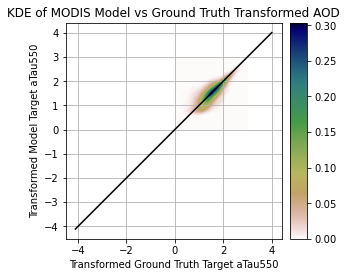

In [8]:
transformed_y_test = aqua_y_test.aTau550
transformed_modis_y_test_aod = aqua_modis_estimate.iloc[test_indices].mTau550
y_test_bins, out_bins_modis, P_modis = calc_kde2d(transformed_y_test, transformed_modis_y_test_aod)
plot_kde2d(y_test_bins, out_bins_modis, P_modis, x_bounds=[0,3], y_bounds=[0,3], Title='KDE of MODIS Model vs Ground Truth Transformed AOD', xLabel='Transformed Ground Truth Target aTau550', yLabel='Transformed Model Target aTau550')

Starting the 2D kernel density estimation with 11917 data points...
Evaluating 2D kernel on grid with (Nx,Ny)=(256,256) ...
X, Y, P shapes:  (256, 256) (256, 256) (256, 256)


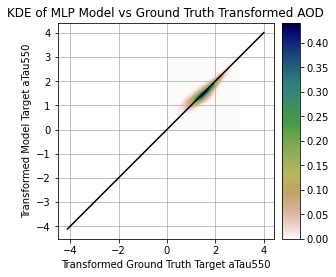

In [9]:
transformed_y_test = aqua_y_test.aTau550
transformed_out_df = aqua_mlp_out.aTau550
y_test_bins, out_bins, P = calc_kde2d(transformed_y_test, transformed_out_df)
plot_kde2d(y_test_bins, out_bins, P, Title='KDE of MLP Model vs Ground Truth Transformed AOD', xLabel='Transformed Ground Truth Target aTau550', yLabel='Transformed Model Target aTau550')

Starting the 2D kernel density estimation with 11917 data points...
Evaluating 2D kernel on grid with (Nx,Ny)=(256,256) ...
X, Y, P shapes:  (256, 256) (256, 256) (256, 256)


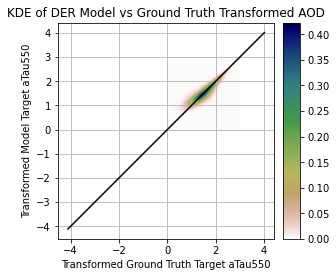

In [10]:
transformed_y_test = aqua_y_test.aTau550
transformed_out_edl_df = aqua_edl_out.aTau550
y_test_bins, out_edl_bins, P_edl = calc_kde2d(transformed_y_test, transformed_out_edl_df)
plot_kde2d(y_test_bins, out_edl_bins, P_edl, Title='KDE of DER Model vs Ground Truth Transformed AOD', xLabel='Transformed Ground Truth Target aTau550', yLabel='Transformed Model Target aTau550')

0.7640112779081715 -0.001218078241409023 0.7731636443915366 0.0 0.005741324069517136
0.7731636443915366


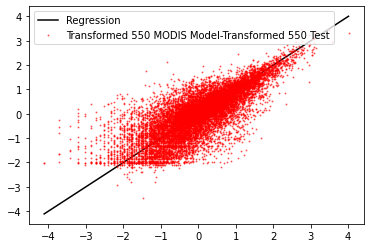

In [11]:
# MODIS lin reg
r = plot_linregress(transformed_y_test, transformed_modis_y_test_aod, np.linspace(transformed_y_test.min(), transformed_y_test.max()), 'Transformed 550 MODIS Model-Transformed 550 Test')
print(r)

0.7758752364231197 0.013916981115875759 0.8861510117906953 0.0 0.0037169776338755833
0.8861510117906953


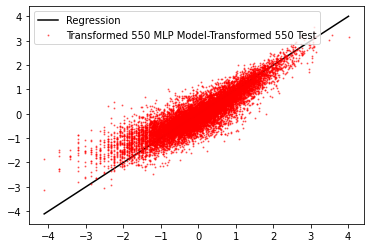

In [12]:
# MLP lin reg
r = plot_linregress(transformed_y_test, transformed_out_df, np.linspace(transformed_y_test.min(), transformed_y_test.max()), 'Transformed 550 MLP Model-Transformed 550 Test')
print(r)

0.7572832027837141 0.030096873118342513 0.8755193400995123 0.0 0.0038287523021114096
0.8755193400995123


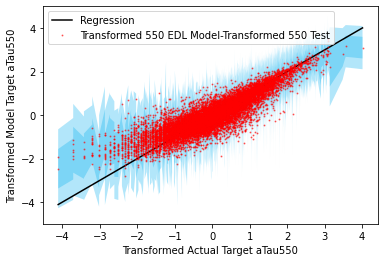

In [13]:
# EDL lin reg
n_stds = 4
std = np.minimum(np.sqrt(aqua_var), 1e3)
r = plot_linregress(transformed_y_test, transformed_out_edl_df, np.linspace(transformed_y_test.min(), transformed_y_test.max()), 'Transformed 550 EDL Model-Transformed 550 Test')
indices = np.argsort(transformed_y_test)
plt.fill_between(
    transformed_y_test[indices], (transformed_out_edl_df[indices] - std[indices][:,1]), (transformed_out_edl_df[indices] + std[indices][:,1]),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1)
plt.fill_between(
    transformed_y_test[indices], (transformed_out_edl_df[indices] - 2*std[indices][:,1]), (transformed_out_edl_df[indices] + 2*std[indices][:,1]),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1)
plt.xlabel('Transformed Actual Target aTau550')
plt.ylabel('Transformed Model Target aTau550')
plt.ylim([-5,5])
print(r)

0.7572832027837141 0.030096873118342513 0.8755193400995123 0.0 0.0038287523021114096
[-0.16357666 -0.69930923 -1.2901804  ...  1.142027    0.42791614
  0.09582911]
0.8755193400995123


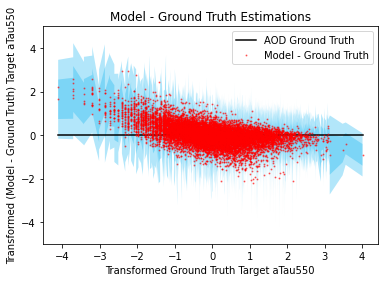

In [14]:
n_stds = 4
std = np.minimum(np.sqrt(aqua_var), 1e3)
r = plot_linregress_diff(transformed_y_test.values, transformed_out_edl_df.values, np.linspace(transformed_y_test.min(), transformed_y_test.max()))
indices = np.argsort(transformed_y_test)
plt.fill_between(
    transformed_y_test[indices], (transformed_out_edl_df[indices] - std[indices][:,1] - transformed_y_test[indices].values), (transformed_out_edl_df[indices] + std[indices][:,1] - transformed_y_test[indices].values),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1)
plt.fill_between(
    transformed_y_test[indices], (transformed_out_edl_df[indices] - 2*std[indices][:,1] - transformed_y_test[indices].values), (transformed_out_edl_df[indices] + 2*std[indices][:,1] - transformed_y_test[indices].values),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1)
plt.xlabel('Transformed Ground Truth Target aTau550')
plt.ylabel('Transformed (Model - Ground Truth) Target aTau550')
plt.legend(loc='best')
plt.ylim([-5,5])
print(r)

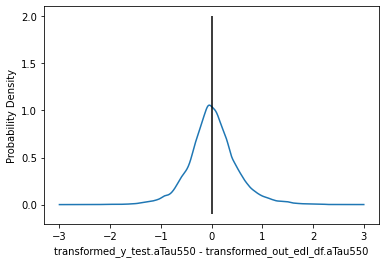

In [17]:
from sklearn.neighbors import KernelDensity
diff_transformed_aod_estimations = transformed_out_edl_df.to_numpy() - transformed_y_test.to_numpy()
kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(diff_transformed_aod_estimations[:, np.newaxis])
X_plot = np.linspace(-3, 3, 1000)[:, np.newaxis]
log_dens = kde.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens))
plt.xlabel('transformed_y_test.aTau550 - transformed_out_edl_df.aTau550')
plt.ylabel('Probability Density')
plt.vlines(0, ymin=-0.1, ymax=2, color='k')